In [ ]:
import pandas as pd
import json

# Specify the file name
file_name = '/content/loan_approval_dataset.json'

# Load the JSON file into a DataFrame
with open(file_name, 'r') as file:
    data = json.load(file)

df = pd.DataFrame.from_dict(data)

# Display the first few rows of the DataFrame
df.head()


,Id,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
0,1,1303834,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,3,13,0
1,2,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13,0
2,3,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,4,10,0
3,4,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12,1
4,5,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,3,14,1


                  Id        Income            Age     Experience  \
count  252000.000000  2.520000e+05  252000.000000  252000.000000   
mean   126000.500000  4.997117e+06      49.954071      10.084437   
std     72746.278255  2.878311e+06      17.063855       6.002590   
min         1.000000  1.031000e+04      21.000000       0.000000   
25%     63000.750000  2.503015e+06      35.000000       5.000000   
50%    126000.500000  5.000694e+06      50.000000      10.000000   
75%    189000.250000  7.477502e+06      65.000000      15.000000   
max    252000.000000  9.999938e+06      79.000000      20.000000   

       CURRENT_JOB_YRS  CURRENT_HOUSE_YRS      Risk_Flag  
count    252000.000000      252000.000000  252000.000000  
mean          6.333877          11.997794       0.123000  
std           3.647053           1.399037       0.328438  
min           0.000000          10.000000       0.000000  
25%           3.000000          11.000000       0.000000  
50%           6.000000          1

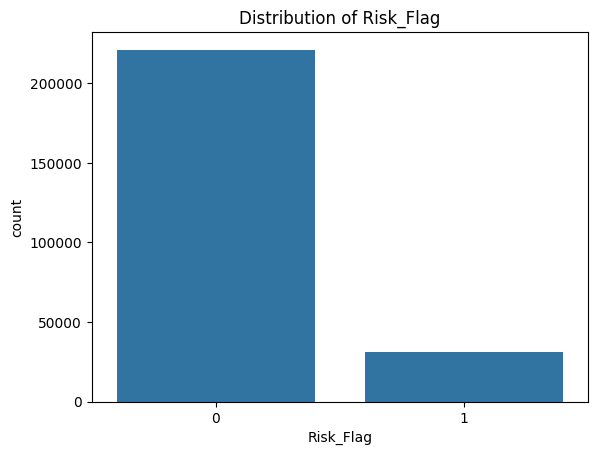

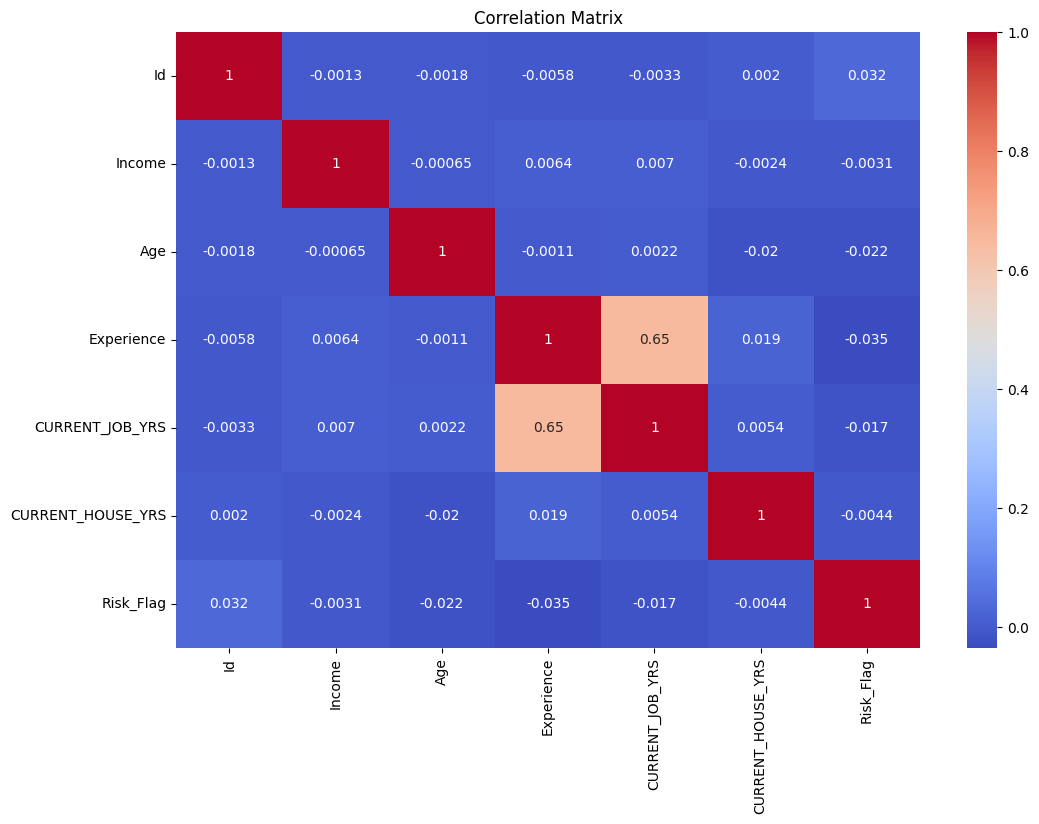

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Basic statistics
print(df.describe())

# Check for missing values
print(df.isnull().sum())

# Visualization: Distribution of Risk_Flag
sns.countplot(x='Risk_Flag', data=df)
plt.title('Distribution of Risk_Flag')
plt.show()

# Visualization: Correlation Matrix (excluding non-numerical columns)
numerical_cols = df.select_dtypes(include=['number']).columns
corr_matrix = df[numerical_cols].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Separate features and target
X = df.drop(columns=['Risk_Flag'])
y = df['Risk_Flag']

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=['number']).columns

# Preprocessing pipeline for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Preprocessing pipeline for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Create a pipeline that includes preprocessing and the classifier
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Model evaluation
print(classification_report(y_test, y_pred))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))
print('ROC AUC Score:', roc_auc_score(y_test, y_pred_proba))


              precision    recall  f1-score   support

           0       0.93      0.96      0.95     44147
           1       0.65      0.46      0.54      6253

    accuracy                           0.90     50400
   macro avg       0.79      0.71      0.74     50400
weighted avg       0.89      0.90      0.89     50400

Confusion Matrix:
[[42564  1583]
 [ 3360  2893]]
ROC AUC Score: 0.9145914081566124


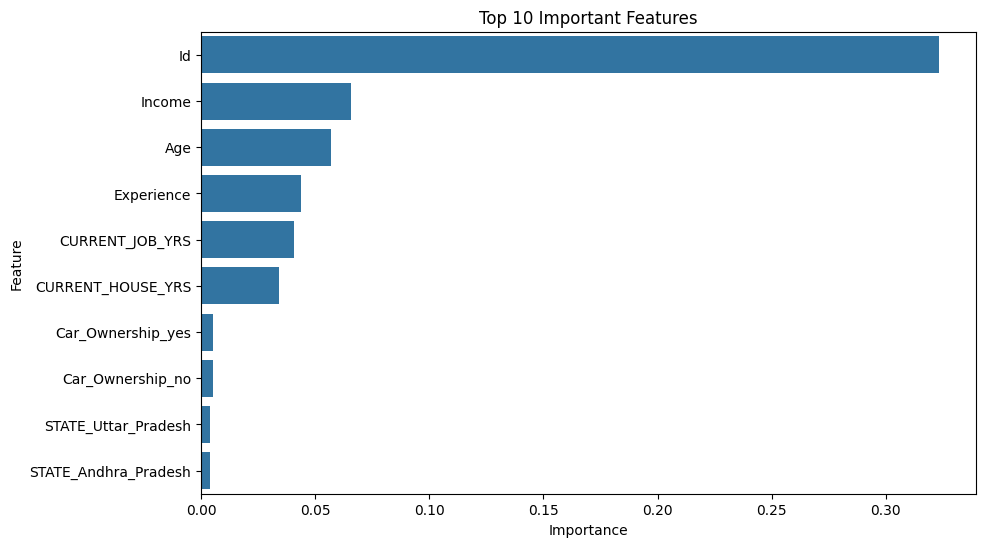

In [ ]:
importances = model.named_steps['classifier'].feature_importances_
features = numerical_cols.tolist() + list(model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_cols))

feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10))
plt.title('Top 10 Important Features')
plt.show()


In [ ]:
from matplotlib.backends.backend_pdf import PdfPages

with PdfPages('/content/Financial_Model_Report.pdf') as pdf:
    # Distribution of Risk_Flag
    plt.figure()
    sns.countplot(x='Risk_Flag', data=df)
    plt.title('Distribution of Risk_Flag')
    pdf.savefig()
    plt.close()

    # Correlation Matrix
    plt.figure()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
    plt.title('Correlation Matrix')
    pdf.savefig()
    plt.close()

    # Top 10 Important Features
    plt.figure()
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10))
    plt.title('Top 10 Important Features')
    pdf.savefig()
    plt.close()




In [ ]:
from google.colab import files
files.download('/content/Financial_Model_Report.pdf')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>